In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn
plt.ion()

import sklearn.svm
import sklearn.tree

## We provide you 3 datasets to play with :
- MNIST in small resolution (8x8 pixels images)
- MNIST, classic: 28x28 resolution 
- Fashion_MNIST, 28x28 resolution

In [2]:
## data set 1 ##
K=10
import sklearn.datasets
X,y = sklearn.datasets.load_digits(n_class=K, return_X_y=True)
linearPictureLength = 8 # Global variable
ratio_train = 0.6 # we may reduce this number when using mnist70 (70 000 images !)
ratio_valid = 0.3 # same here

In [5]:
## data set 2 ##
LoadObject = np.load("/home/flandes/data/mnist70.npz")
linearPictureLength = 28
X = LoadObject['X']
y = LoadObject['y']
del LoadObject
ratio_train = 0.005
ratio_valid = 0.1
print(X.shape)

(70000, 784)


In [6]:
## data set 3 ##
LoadObject = np.load("/home/flandes/data/fashion-mnist-reshaped.npz")
linearPictureLength = 28
X = LoadObject['train_images']
y = LoadObject['train_labels']
Xtest = LoadObject['test_images']
ytest = LoadObject['test_labels']
X     = np.array(X    , dtype=float) ## change the type, which is iniitially unsigned-int (uint)
Xtest = np.array(Xtest, dtype=float)
del LoadObject
ratio_train = 0.05
ratio_valid = 0.1
print(X.shape)

(60000, 784)


## We load the data and split it into train, validation and test set.

It's good to do this early, and remember to only use the train set for most operations.

The validation set may be used to find the best hyper-parameters

The test can be used.. only **once** ! Then it "expires", like old food is wasted after a couple of weeks.

In [7]:
def load_subSets(X, ratio_train, ratio_valid):
    ratio_test = 1 - ratio_train - ratio_valid #
    assert(ratio_test>0)
    Ntot   = X.shape[0]
    Ntrain = int(ratio_train*Ntot)
    Nvalid = int(ratio_valid*Ntot)
    Ntest  = Ntot - Ntrain - Nvalid
    X_train = X[0: Ntrain].copy()
    y_train = y[0: Ntrain].copy()
    X_valid = X[Ntrain:Ntrain+Nvalid].copy() #  X[-Ntest:] also does the same
    y_valid = y[Ntrain:Ntrain+Nvalid].copy() # 
    X_test  = X[-Ntest:].copy()
    y_test  = y[-Ntest:].copy()
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [8]:
## actually load the data into separate arrays
X_train, y_train, X_valid, y_valid, X_test, y_test = load_subSets(X, ratio_train, ratio_valid)
X_train.shape

(3000, 784)

# First part: getting a sense of what PCA does

## 1.1 Normalization

- take a quick look at the data: what does it look like ? What are the min and max values ?
- normalize the input so all values of the training set are between 0 and 1. Perform the appropriate operation on the val and test sets so that they are consistent with this pre-processing operation.

9


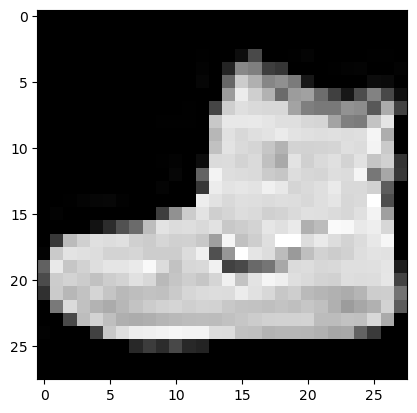

In [9]:
n=0
plt.imshow(X_train[n].reshape(linearPictureLength, linearPictureLength) , cm.gray)
print(y[n])

In [10]:
# print(X.shape, X[n], y[n])

## Normalization: here we choose to simply perform min-max normalization

What are the other choices ?

Other common pre-processing choices are:
- standardization (subtract the mean, divide by the standard deviation)
- simple centering (subtract only the mean)
- PCA (!)

In [11]:
# we set X (the gray levels) between 0 and 1
max_level = X_train.max()*1.0
X_train /= max_level
X_valid /= max_level
X_test  /= max_level

# Remark !

We divide each sub-part of the data by the **same** value, not each by its max !

This is important: in the spirit of pre-processing and train/val/test split, you must use only the training data to pre-process (all) the data, including the validation and test sets.

The pipeline is not supposed to know in advance hte maximum value of the validation or test sets !


## 1.2 Your first PCA compression (+decompression)


We want to see what typical PCA does on an image.
- using the method `sklearn.decomposition.PCA` from the `scikit-learn` library, compress the training set (i.e. perform its PCA). Then, decompress this compressed version, and compare an image before and after its transformation.  For this, you will need to :
    - define an instance of the class `sklearn.decomposition.PCA`, that we may call "model" or "preProcessing"
    - use the methods `fit`, `transofrm` and `inverse_transform`
    - use the plot funciton  `plot_before_vs_after_compression` that we provide below
    - remember to make copies, not in-place transformation !
    - to start, you can use an explained variance ratio of 95%
- compare a couple of images (pick random images, just to take a look not just at 1 case)
- compute the Squared Error (squared difference between original and compresse+decompressed images) for a single image.
- compute the Mean Squared Error (same thing but averaged on all training set images).
- by browsing the methods of `sklearn.decomposition.PCA`, find a way to display the *explained variance ratio*, for all possible values of the number of PCA components to be kept. Plot it on a graph.
- display the before/after image comparison for a low number of components, e.g. 30

In [12]:
def plot_before_vs_after_compression(n, X_train, X_train_Transf_decompressed, y):
    plt.figure()
    plt.imshow(X_train[n].reshape(linearPictureLength, linearPictureLength) , cm.gray)
    plt.title("this is supposed to look like a "+str(y[n])+ " before compression")
    plt.savefig(str(n)+"_beforeCompression.png")

    plt.figure()
    plt.imshow(X_train_Transf_decompressed[n].reshape(linearPictureLength, linearPictureLength) , cm.gray)
    plt.title("this is supposed to look like a "+str(y[n])+ " after compression+decompression")
    plt.savefig(str(n)+"_afterCompression.png")

    print("The MSE for this image is ", np.mean( (X_train[n]- X_train_Transf_decompressed[n])**2) )

The MSE for this image is  145.40920372231966
MSE totale (Mean Squared Error) 282.85687413564705


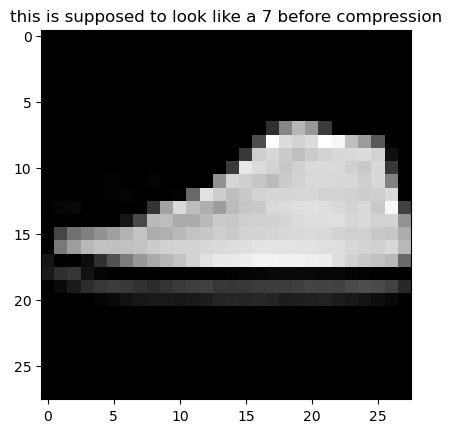

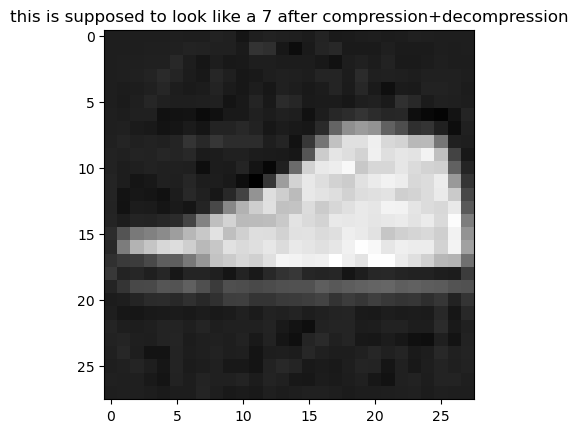

In [13]:
### 1st attempt at PCA with an explained_variance ratio set to 0.95

X_train, y_train, X_valid, y_valid, X_test, y_test = load_subSets(X, ratio_train, ratio_valid)

varianceExplained=0.95
preProc = sklearn.decomposition.PCA(n_components=varianceExplained, copy=True)
preProc.fit(X_train)

X_train_Transformed = preProc.transform(X_train)
X_train_Transf_decompressed = preProc.inverse_transform(X_train_Transformed)

n=41 # image number 42 (41+1)
plot_before_vs_after_compression(n, X_train, X_train_Transf_decompressed, y)

diff = X_train_Transf_decompressed - X_train
totalMeanSquaredError = np.mean(diff**2)
print("MSE totale (Mean Squared Error)", totalMeanSquaredError)

(0.0, 1.0)

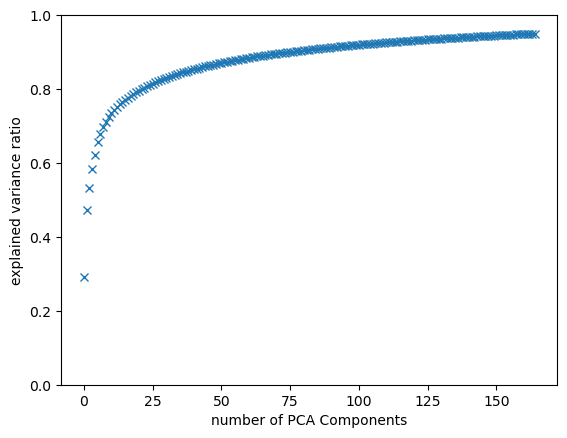

In [14]:
## displaying the total variance explained at various values of nComp
CumulativeExplainedVariance = np.cumsum(preProc.explained_variance_ratio_)
plt.plot(CumulativeExplainedVariance, ls= "", marker='x')
plt.xlabel("number of PCA Components")
plt.ylabel("explained variance ratio")
plt.ylim([0,1])

The MSE for this image is  52.63949442092677


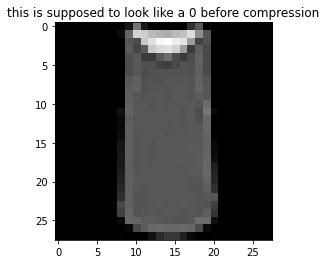

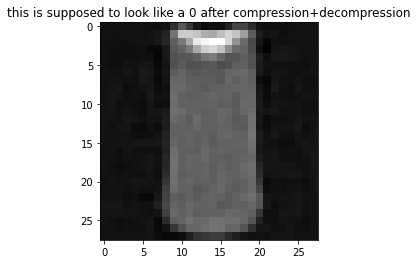

In [13]:
plot_before_vs_after_compression(2, X_train, X_train_Transf_decompressed, y)

The MSE for this image is  945.5059095825783


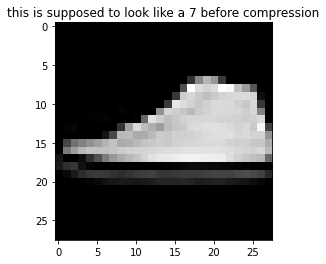

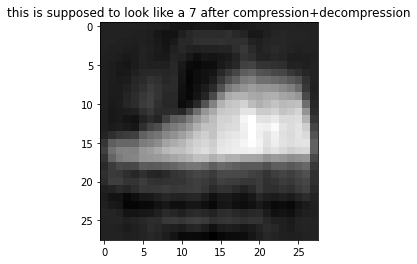

In [14]:
# varianceExplained=30 # 30 compnents
preProc = sklearn.decomposition.PCA(n_components=30, copy=True)
preProc.fit(X_train)
X_train_Transformed = preProc.transform(X_train)
X_train_Transf_decompressed = preProc.inverse_transform(X_train_Transformed)

n=41 # image number 42 (41+1)
plot_before_vs_after_compression(n, X_train, X_train_Transf_decompressed, y)


## Comments:

- The explained variance monotonously increases with the number of components, as expected.
- even with few components, the compression is not so bad !